In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchtext.vocab import GloVe

In [26]:
glove = GloVe(name='6B', dim=100)

# Define the tokens you want to add
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
EOS_TOKEN = '<eos>'

# Create new embeddings for the tokens and concatenate them with the GloVe embeddings
pad_embedding = torch.zeros((1, glove.dim))
unk_embedding = torch.randn((1, glove.dim))
sos_embedding = torch.randn((1, glove.dim))

new_embeddings = torch.cat([glove.vectors, pad_embedding, unk_embedding, sos_embedding], dim=0)

In [27]:
# Create the embedding layer and load the embeddings
embedding = nn.Embedding.from_pretrained(new_embeddings, freeze=True)

In [28]:
type(embedding)

torch.nn.modules.sparse.Embedding

In [29]:
from datasets import load_dataset

nli = load_dataset("multi_nli")

  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
nli

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})

In [31]:
import re
from collections import Counter
from nltk.tokenize import word_tokenize

sentences = nli['train']['premise'][:10000]+nli['train']['hypothesis'][:10000]
token_counts = Counter()

for sentence in sentences:
    tokens = re.findall(r'\w+|[.-/]', sentence)
#     tokens = word_tokenize(sentence.lower())
    token_counts.update(tokens)

vocab = set(token_counts.keys())
vocab_size = len(vocab)

# Special tokens
unk_token = '<unk>'
pad_token = '<pad>'
eos_token = '<eos>'

# Check if the special tokens are in the vocabulary
if unk_token not in vocab:
    vocab_size += 1
if pad_token not in vocab:
    vocab_size += 1
if eos_token not in vocab:
    vocab_size += 1

vocab_size

24002

In [32]:
# # Extract the sentences column
sentences_train =  nli['train']['premise'][:10000]+nli['train']['hypothesis'][:10000]
sentences_val =  nli['validation_matched']['premise'][:1000]+nli['validation_matched']['hypothesis'][:1000]+nli['validation_mismatched']['premise'][:1000]+nli['validation_mismatched']['hypothesis'][:1000]

word_to_idx = {word: i for i, word in enumerate(glove.itos)}

In [33]:
new_embeddings = torch.randn(vocab_size, 100)

In [35]:
word2idx = {word: i for i, word in enumerate(vocab)}
word2idx['<unk>'] = len(word2idx)
word2idx['<eos>'] = len(word2idx)
word2idx['<pad>'] = len(word2idx)

In [36]:
word2idx['<pad>']

24001

In [37]:
word_to_idx['unk']

201534

In [57]:
import pickle

# Save the word2idx dictionary
with open('word2idx_nli.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [58]:
# Load the saved word2idx dictionary
with open('word2idx_nli.pickle', 'rb') as handle:
    word2idx = pickle.load(handle)

In [38]:
# Train the model on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
for word in vocab:
    if word.lower() in word_to_idx:
        idx = word_to_idx[word.lower()]
    else:
        idx = word_to_idx['unk']
    word_embedding = embedding(torch.tensor(idx))
    new_embeddings[word2idx[word]] = word_embedding

In [40]:
new_embeddings.shape

torch.Size([24002, 100])

In [41]:
torch.save(new_embeddings, 'new_embeddings_nli.pt')

In [42]:
new_embeddings = torch.load('new_embeddings_nli.pt')

In [43]:
import torch
from torch.utils.data import Dataset

class NLIDataset(Dataset):
    def __init__(self, sentences, word_to_idx, max_len):
        self.sentences = sentences
        self.word_to_idx = word_to_idx
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
#         tokens = sentence.strip().split()
        tokens = re.findall(r'\w+|[.-/]', sentence)
        while(len(tokens)<self.max_len):
            tokens.append('<pad>')
        if(len(tokens)>self.max_len):
            tokens = tokens[:self.max_len-1]
            tokens.append('<eos>')
        input_tokens = [self.word_to_idx.get(token.lower(), self.word_to_idx['<unk>']) for token in tokens]
        target_tokens = input_tokens[1:] + [self.word_to_idx['<eos>']]
        return torch.LongTensor(input_tokens), torch.LongTensor(target_tokens)


In [44]:
# Create the training and validation datasets
train_dataset = NLIDataset(sentences_train, word2idx, 100)
val_dataset = NLIDataset(sentences_val, word2idx, 100)

In [45]:
class ELMo(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dropout):
        super(ELMo, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(new_embeddings, freeze=True, sparse=True)
        self.hidden_size = embedding_dim//2
        self.lstm1 = nn.LSTM(input_size=embedding_dim,
                             hidden_size=embedding_dim//2,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=True,
                             dropout=dropout
                            )
        self.lstm2 = nn.LSTM(input_size=embedding_dim,
                             hidden_size=embedding_dim//2,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=True,
                             dropout=dropout)
        self.fc = nn.Linear(embedding_dim, vocab_size)
        self.gamma = nn.Parameter(torch.ones(1))
        self.weights = [0.2, 0.4, 0.4]

    def forward(self, x):
        embeds = self.embedding(x)  # shape: (batch_size, max_seq_length, embedding_dim)

        lstm1_out, _ = self.lstm1(embeds)  # shape: (batch_size, max_seq_length, hidden_size*2)
        lstm2_out, _ = self.lstm2(lstm1_out)  # shape: (batch_size, max_seq_length, hidden_size*2)
        output = self.fc(lstm2_out)  # shape: (batch_size, max_seq_length, vocab_size)
        
        elmo_embeddings = self.gamma * (self.weights[0]*embeds + self.weights[1]*lstm1_out + self.weights[2]*lstm2_out) # shape: (batch_size, max_seq_length, 2*hidden_size)

        return output, elmo_embeddings


In [46]:
for a in train_dataset:
    print(a)
    break

(tensor([23108,  6816, 12545,   871, 19460, 17271,  9080, 14011,  6934, 11271,
         5712, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001,
        24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001,
        24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001,
        24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001,
        24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001,
        24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001,
        24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001,
        24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001,
        24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001]), tensor([ 6816, 12545,   871, 19460, 17271,  9080, 14011,  6934, 11271,  5712,
        24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001, 24001,
        24001, 24001, 24001, 24001, 24001, 24001, 24001, 2400

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

# Hyperparameters
VOCAB_SIZE = vocab_size
EMBEDDING_DIM = 100
# HIDDEN_SIZE = 512
DROPOUT = 0.2
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NUM_EPOCHS = 50

# Create model, optimizer, and loss function
# model = ELMo(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, DROPOUT)
model = ELMo(VOCAB_SIZE, EMBEDDING_DIM, DROPOUT)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:70: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [48]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
for i, (inputs, targets) in enumerate(train_loader):
    print(targets.squeeze())
    print(inputs.shape)
    break

tensor([[20954, 16222, 14003,  ..., 24001, 24001, 24000],
        [22862,  5430,  1119,  ..., 24001, 24001, 24000],
        [ 1678, 23999, 22527,  ..., 24001, 24001, 24000],
        ...,
        [12871,  5532, 19413,  ..., 24001, 24001, 24000],
        [ 3541, 15283,  1678,  ..., 24001, 24001, 24000],
        [23999,  5712, 23999,  ..., 24001, 24001, 24000]])
torch.Size([32, 100])


In [52]:
losses = []
model.to(device)

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs[0].view(-1, vocab_size)
        targets = targets.view(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i+1) % BATCH_SIZE == 0:
            losses.append(running_loss / BATCH_SIZE)
            running_loss = 0.0
        
    print('[Epoch %d, Batch %5d] loss: %.3f' %
            (epoch+1, i+1, running_loss / BATCH_SIZE))
    running_loss = 0.0

print('Finished Training')

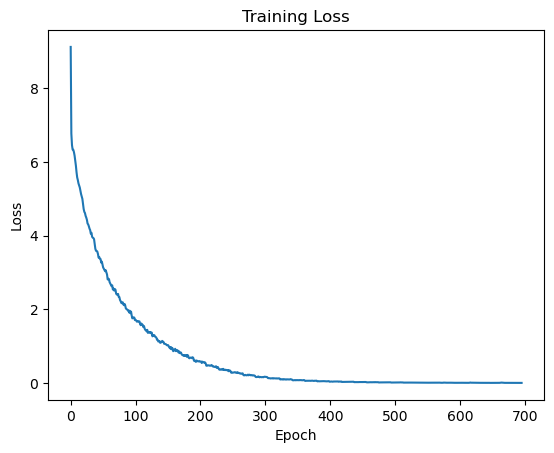

Final Training Loss: 0.003121202069451101


In [51]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print('Final Training Loss:', losses[-1])

In [83]:
# # 0.14
# model.to(device)

# losses = []
# for epoch in range(NUM_EPOCHS):
#     running_loss = 0.0
#     for i, (inputs, targets) in enumerate(train_loader):
#         inputs, targets = inputs.to(device), targets.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         outputs = outputs[0].view(-1, vocab_size)
#         targets = targets.view(-1)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#         if (i+1) % BATCH_SIZE == 0:
#             losses.append(running_loss / BATCH_SIZE)
#             running_loss = 0.0
        
        
#     print('[Epoch %d, Batch %5d] loss: %.3f' %
#             (epoch+1, i+1, running_loss / BATCH_SIZE))
#     running_loss = 0.0

# print('Finished Training')


In [53]:
torch.save(model.state_dict(), 'elmo_model_nli.pt')

In [54]:
model.load_state_dict(torch.load('elmo_model_nli.pt'))

<All keys matched successfully>

In [59]:
import torch
from nltk.tokenize import word_tokenize

# Define a function to convert a sentence to a tensor of word indices
def sentence_to_tensor(sentence, word2idx):
    tokens = word_tokenize(sentence.lower())
    indices = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
    tensor = torch.LongTensor(indices).unsqueeze(0)  # add batch dimension
    return tensor

# Define a function to get the ELMo embeddings of a sentence
def get_elmo_embeddings(sentence, model, word2idx):
    with torch.no_grad():
        # Convert the sentence to a tensor of word indices
        inputs = sentence_to_tensor(sentence, word2idx)
        
        # Get the ELMo embeddings
        _, elmo_embeddings = model(inputs.to(device))
        
        # Remove the batch dimension
        elmo_embeddings = elmo_embeddings.squeeze(0)
        
        return elmo_embeddings
    
# Define a function to convert a sentence to a tensor of word indices
def sentence_to_tensor_padded(sentence, word2idx, pad):
    tokens = word_tokenize(sentence.lower())
    while(len(tokens)<pad):
        tokens.append('<pad>')
    if(len(tokens)>pad):
            tokens = tokens[:pad-1]
            tokens.append('<eos>')
    indices = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
    tensor = torch.LongTensor(indices).unsqueeze(0)  # add batch dimension
    return tensor
    
# Define a function to get the ELMo embeddings of a sentence
def get_elmo_embeddings_padded(sentence, model, word2idx, pad):
    with torch.no_grad():
        # Convert the sentence to a tensor of word indices
        inputs = sentence_to_tensor_padded(sentence, word2idx, pad)
        
        # Get the ELMo embeddings
        _, elmo_embeddings = model(inputs.to(device))
        
        # Remove the batch dimension
        elmo_embeddings = elmo_embeddings.squeeze(0)
        
        return elmo_embeddings


In [60]:
# Define a sentence
sentence = "I love pizza"
sentence2 = "I love pasta"
 
# Get the ELMo embeddings of the sentence
elmo_embeddings = get_elmo_embeddings(sentence, model, word2idx)
elmo_embeddings2 = get_elmo_embeddings(sentence2, model, word2idx)

In [61]:
print(elmo_embeddings.shape)

torch.Size([3, 100])


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [63]:
class NliDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]


In [64]:
nli

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})

In [65]:
word2idx['<pad>']

24001

In [66]:
data = []
labels = []
for i, sentence in enumerate(nli['train']):
    if(i==10000): break
    s1 = sentence['premise']
    s2 = sentence['hypothesis']
    data.append([get_elmo_embeddings_padded(s1, model, word2idx, 100).float(), get_elmo_embeddings_padded(s2, model, word2idx, 100).float()])
    labels.append(sentence['label'])

In [67]:
nli_train_dataset = NliDataset(data, labels)
nli_train_loader = DataLoader(nli_train_dataset, batch_size=32, shuffle=True)

In [68]:
data = []
labels = []
for i, sentence in enumerate(nli['train']):
    if(i>10000):
        s1 = sentence['premise']
        s2 = sentence['hypothesis']
        data.append([get_elmo_embeddings_padded(s1, model, word2idx, 100).float(), get_elmo_embeddings_padded(s2, model, word2idx, 100).float()])
        labels.append(sentence['label'])
    if(i==12000): break

In [69]:
nli_val_dataset = NliDataset(data, labels)
nli_val_loader = DataLoader(nli_val_dataset, batch_size=32, shuffle=True)

In [70]:
data = []
labels = []
for i, sentence in enumerate(nli['train']):
    if(i>12000):
        s1 = sentence['premise']
        s2 = sentence['hypothesis']
        data.append([get_elmo_embeddings_padded(s1, model, word2idx, 100).float(), get_elmo_embeddings_padded(s2, model, word2idx, 100).float()])
        labels.append(sentence['label'])
    if(i==18000): break
        
nli_test_dataset = NliDataset(data, labels)
nli_test_loader = DataLoader(nli_test_dataset, batch_size=32, shuffle=True)

In [71]:
import torch
import torch.nn as nn

class NLIModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(NLIModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True).to(device)
        self.attention = nn.Linear(hidden_dim * 4, 1).to(device)
        self.fc = nn.Linear(hidden_dim * 4, 3).to(device)

    def forward(self, x):
        premise_emb = x[0].float().to(device) # move premise_emb to GPU
        hypothesis_emb = x[1].float().to(device) # move hypothesis_emb to GPU

        _, (premise_hidden, _) = self.lstm(premise_emb)
        _, (hypothesis_hidden, _) = self.lstm(hypothesis_emb)

        premise_hidden = torch.cat([premise_hidden[-2], premise_hidden[-1]], dim=1)
        hypothesis_hidden = torch.cat([hypothesis_hidden[-2], hypothesis_hidden[-1]], dim=1)

        attention_input = torch.cat([premise_hidden, hypothesis_hidden], dim=1)
        attention_logits = self.attention(attention_input)
        attention_weights = torch.softmax(attention_logits, dim=1)
        attended_input = attention_weights * attention_input

        output = self.fc(attended_input)

        return output


In [75]:
learning_rate = 0.001
num_epochs = 10
batch_size = 64
hidden_size = 512
num_layers = 2
dropout = 0.2
input_size = 100
output_size = 1

In [78]:
nli_model = NLIModel(vocab_size, 100, hidden_size)

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses = []
val_losses = []

nli_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nli_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    # Training
    nli_model.train()
    for data, labels in nli_train_loader:
        optimizer.zero_grad()
        outputs = nli_model(data)
        labels = labels.long().to(device) # move labels to GPU
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 
    
    # Validation
    nli_model.eval()
    with torch.no_grad():
        for data, labels in nli_val_loader:
            outputs = nli_model(data)
            labels = labels.long().to(device) # move labels to GPU
            loss = criterion(outputs, labels)
            val_loss += loss.item() 
            
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Print epoch statistics
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/10, Train Loss: 0.0169, Val Loss: 0.0165
Epoch 2/10, Train Loss: 0.0163, Val Loss: 0.0163
Epoch 3/10, Train Loss: 0.0160, Val Loss: 0.0163
Epoch 4/10, Train Loss: 0.0159, Val Loss: 0.0159
Epoch 5/10, Train Loss: 0.0156, Val Loss: 0.0161
Epoch 6/10, Train Loss: 0.0153, Val Loss: 0.0161
Epoch 7/10, Train Loss: 0.0150, Val Loss: 0.0164
Epoch 8/10, Train Loss: 0.0145, Val Loss: 0.0166
Epoch 9/10, Train Loss: 0.0136, Val Loss: 0.0170
Epoch 10/10, Train Loss: 0.0125, Val Loss: 0.0180


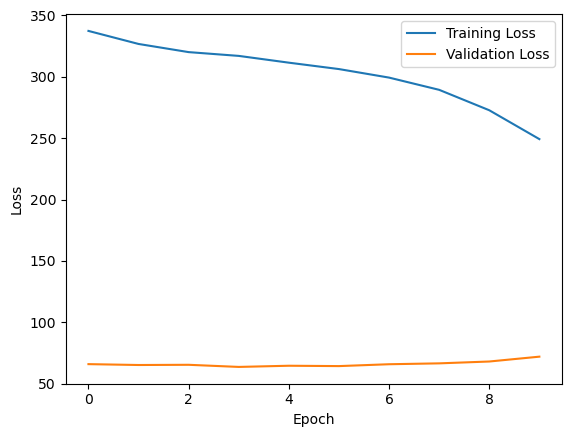

In [80]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [81]:
torch.save(nli_model.state_dict(), 'model_nli.pt')

In [83]:
nli_model.load_state_dict(torch.load('model_nli.pt'))

<All keys matched successfully>

In [84]:
for data, labels in nli_val_loader:
    print(data[0].shape)
    break

torch.Size([32, 100, 100])


In [86]:
def getCategory(premise, hypothesis):
    pndh = [get_elmo_embeddings_padded(premise, model, word2idx, 100).float().reshape(1, 100, 100), get_elmo_embeddings_padded(hypothesis, model, word2idx, 100).float().reshape(1, 100, 100)]
    out = nli_model(pndh)
    return torch.argmax(out)

In [88]:
premise = "The fourth-century Roman emperor Gratianus was an early visitor, followed much later by such luminaries as the Romantic poet Alphonse de Lamartine, Queen Victoria, Saint-Sa?«ns, and Rachmaninov."
hypothesis = "Gratianus was a Roman empoeror."
getCategory(premise, hypothesis)

tensor(2, device='cuda:0')